In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = "{}{}-{}".format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = "cu80" if path.exists("/opt/bin/nvidia-smi") else "cpu"

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [289]:
!pip install Pillow==4.0.0
!pip install image

  Using cached Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0


In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn import metrics

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

EPOCHS_TO_TRAIN = 20

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.5)

rcParams["figure.figsize"] = 12, 8

In [0]:
!mkdir -p data

In [295]:
!wget http://files.fast.ai/data/cifar10.tgz

--2018-03-08 15:47:28--  http://files.fast.ai/data/cifar10.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168168549 (160M) [text/plain]
Saving to: ‘cifar10.tgz.7’

cifar10.tgz.7       100%[===================>] 160.38M  25.8MB/s    in 8.8s    

2018-03-08 15:47:37 (18.2 MB/s) - ‘cifar10.tgz.7’ saved [168168549/168168549]



In [0]:
!tar -xzf cifar10.tgz -C data/

In [0]:
PATH = "data/cifar10/"

In [298]:
!ls {PATH}/

labels.txt  test  train


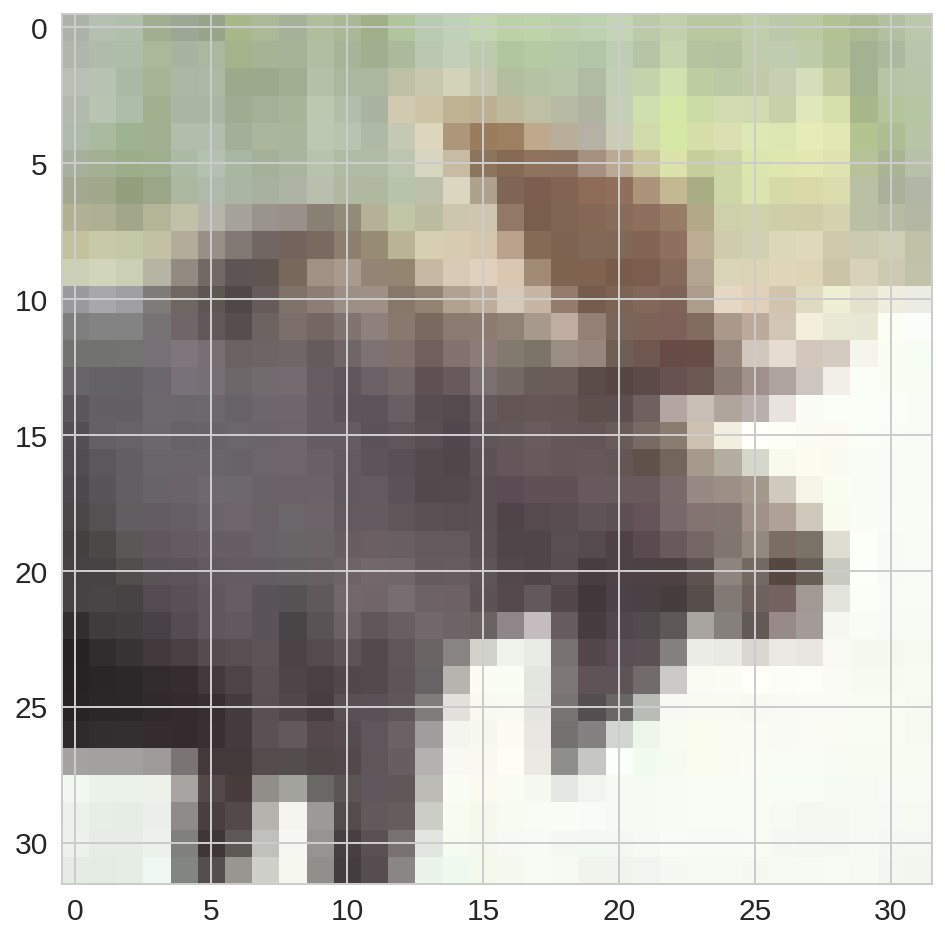

In [299]:
img = plt.imread(f"{PATH}test/deer/8126_deer.png")
plt.imshow(img);

In [300]:
img.shape

(32, 32, 3)

In [0]:
import torch.utils.data as data
import torchvision.datasets as datasets
import os

traindir = PATH + "train"
testdir = PATH + "test"

train_loader = data.DataLoader(
        datasets.ImageFolder(traindir,
                             transforms.Compose([
                                 transforms.ToTensor()
                             ])),
        batch_size=64,
        shuffle=True,
        pin_memory=True)

test_loader = data.DataLoader(
        datasets.ImageFolder(testdir,
                        transforms.Compose([
                            transforms.ToTensor()
                        ])),
        batch_size=64,
        shuffle=False,
        pin_memory=False)

In [302]:
len(train_loader.dataset.imgs)

50000

In [303]:
len(test_loader.dataset.imgs)

10000

In [0]:
batch = next(iter(train_loader))

In [0]:
X, y = batch

In [306]:
X[0].shape

torch.Size([3, 32, 32])

In [0]:
def show_image(tensor_data):
  im = tensor_data.numpy()
  im = np.transpose(im, (1,2,0))
  plt.imshow(im)
  plt.show()

In [308]:
y[0]

7

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*4*4, 100)
        self.fc1_drop = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        c1 = self.conv1(x)
        x = F.relu(self.pool1(c1))
        c2 = self.conv2(x)
        x = F.relu(self.pool2(c2))  
        c3 = self.conv3(x)
        x = F.relu(self.pool3(c3))     
        x = x.view(-1, 64*4*4)
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)
        return x

In [0]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [311]:
train_loss = []
test_loss = []


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        

        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    Average train loss: {mean_train_loss}
    Average test loss: {mean_test_loss}
    Test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")



    ######### Epoch 1 #########

    Average train loss: 1.5733167758530668
    Average test loss: 1.2325246193606383
    Test accuracy: 5512/10000 55.12%


    ######### Epoch 2 #########

    Average train loss: 1.176994478687301
    Average test loss: 1.058238268278207
    Test accuracy: 6253/10000 62.53%


    ######### Epoch 3 #########

    Average train loss: 1.0109102362409577
    Average test loss: 0.9608510702278963
    Test accuracy: 6589/10000 65.89%


    ######### Epoch 4 #########

    Average train loss: 0.9174554447841157
    Average test loss: 0.9264934882996189
    Test accuracy: 6699/10000 66.99%


    ######### Epoch 5 #########

    Average train loss: 0.8311935285549334
    Average test loss: 0.9211980110141123
    Test accuracy: 6792/10000 67.92%


    ######### Epoch 6 #########

    Average train loss: 0.7697968008115773
    Average test loss: 0.8533495275457953
    Test accuracy: 7091/10000 70.91%


    ######### Epoch 7 #########

    Average train loss: 0.

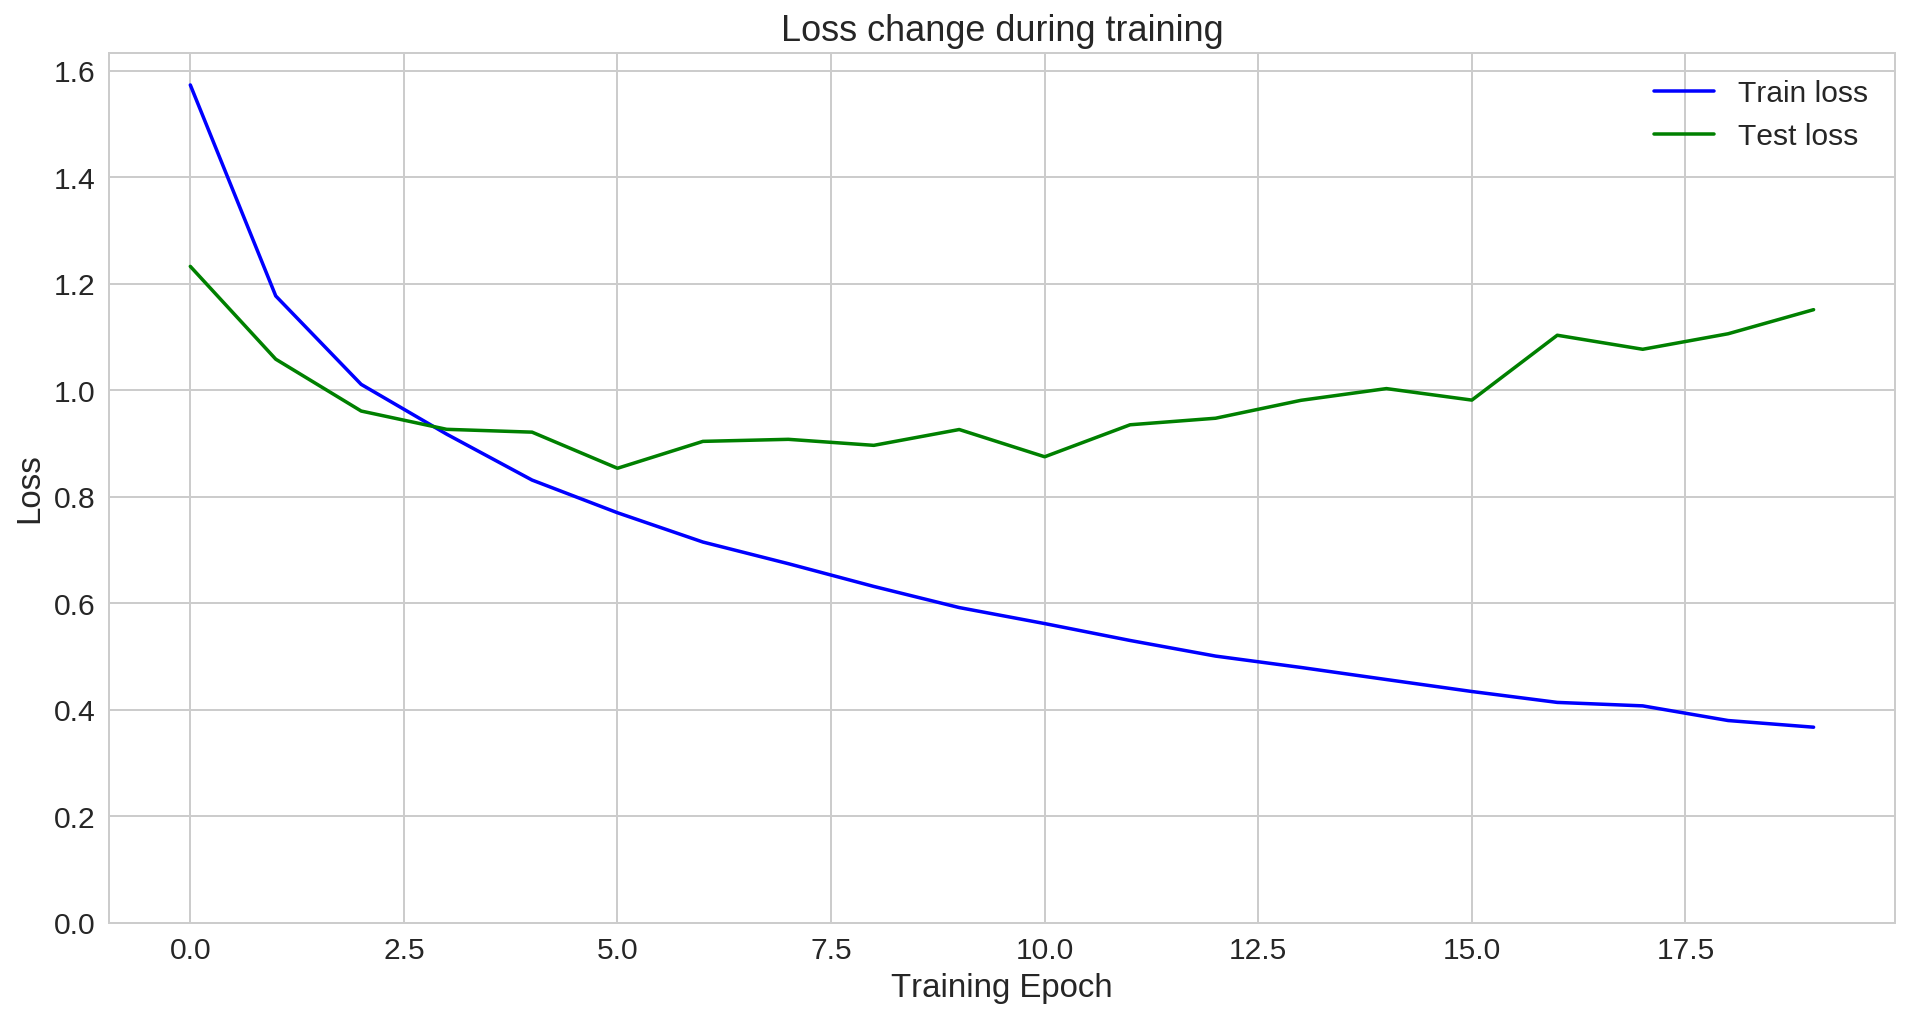

In [312]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc="upper right", shadow=True)
plt.ylabel("Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)

plt.show()

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

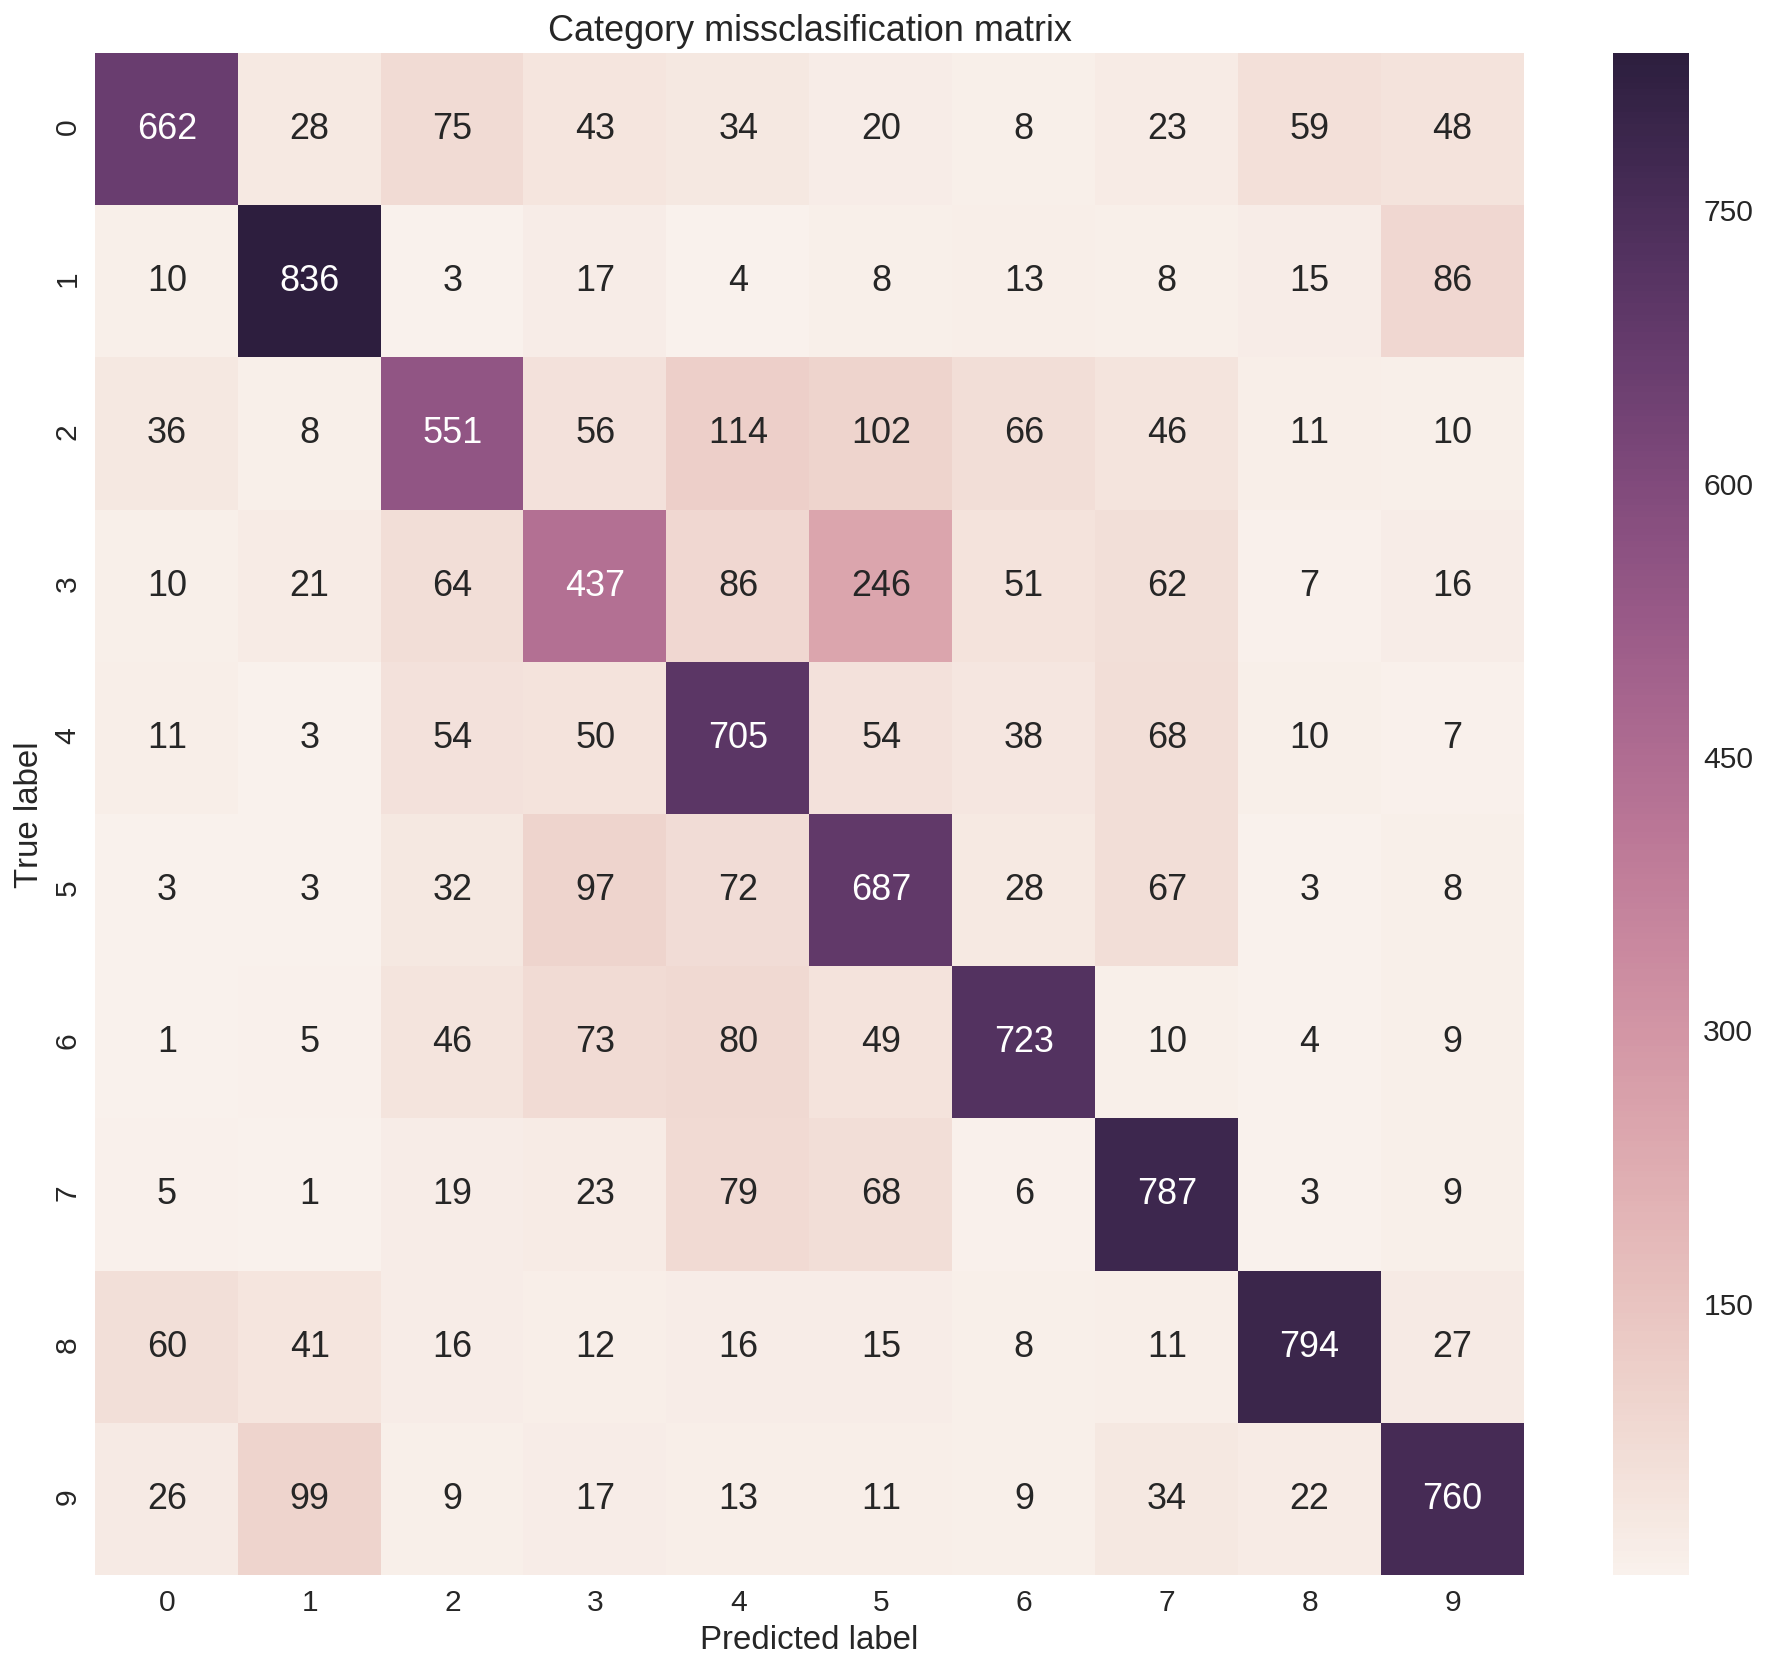

In [314]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Category missclasification matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show();